In [1]:
import numpy as np
import matplotlib.pyplot as plt
import run_simple_energy_loss

In [2]:
simulation=run_simple_energy_loss.run_simulation

In [3]:
pT_range = (1, 10, 10) # Compute more observable than needed to avoid boundry unstabilities.
pT_obs = [3, 5, 7] # p_T Observables we will use for the analysis

In [4]:
from emukit.core import ParameterSpace, ContinuousParameter

In [5]:
prior_ranges= {'alpha_s':(0.05,0.5), 'exponent_inel':(-3,3), 'exponent_el':(-3,3), 'scale_inel':(0.1, 0.5), 'scale_el':(0.1, 0.5)}
true_values= {'alpha_s': 0.2, 'exponent_inel': -1, 'exponent_el': 1, 'scale_inel': 0.3, 'scale_el': 0.3}
name_to_position =  {'alpha_s':0, 'exponent_inel':1, 'exponent_el':2, 'scale_inel':3, 'scale_el':4}

In [6]:
# We will generate observable for these model parametr values and consider them as experimental data
truth = np.array(list(true_values.values())).reshape(1,-1)
print(truth)

[[ 0.2 -1.   1.   0.3  0.3]]


Working on 1/1 design


/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


Text(0.5, 1.0, 'Experimental observations')

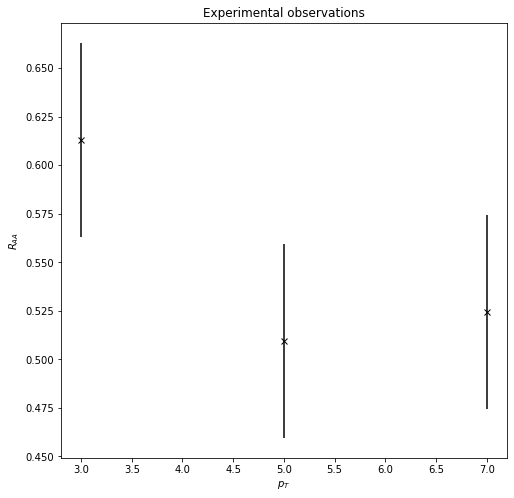

In [7]:
# Set seed for reproducibility.
seed = 42
np.random.seed(seed)

# Generate some synthetic data from the model.
x = np.array(pT_obs)
N = len(x)
obserr = 0.05 # Amplitude of noise term
obs = simulation(truth, *pT_range)[:,pT_obs] # True model
obs += obserr * np.random.randn(N) # Add some random noise

# Now plot it to see what the data looks like
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x.flatten(), obs.flatten(), yerr=obserr, fmt="xk", capsize=0)
#ax.plot(x.flatten(), obs.flatten(), "k", alpha=0.3, lw=3)
#ax.set_xlim(0, 10)
ax.set_xlabel(r"$p_T$")
ax.set_ylabel(r"$R_{AA}$")
ax.set_title('Experimental observations')

In [8]:
parameter_space = ParameterSpace([ContinuousParameter('alpha_s', 0.05,0.5 ),
                                  ContinuousParameter('exponent_inel', -3, 3),
                                  ContinuousParameter('exponent_el', -3, 3),
                                  ContinuousParameter('scale_inel', 0.1, 0.5),
                                  ContinuousParameter('scale_el', 0.1, 0.5)])

In [9]:
from emukit.core.initial_designs import RandomDesign

design = RandomDesign(parameter_space)
num_data_points = 5
X = design.get_samples(num_data_points)
print(f'Shape of X {X.shape}')

Shape of X (5, 5)


In [10]:
def f(design):
    """returns simulation output for a design matrix"""
    print(design.shape)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT_obs]

In [11]:
from GPy.kern import RBF, White
from GPy.models import GPRegression
from emukit.model_wrappers import GPyMultiOutputWrapper


### Let's build a emulator for each observable (3 in total) and query 5 points for each emulator at a time.  
## Or actually no need. Let's try the multioutput model wrapper first

In [12]:
# size of possible variation of parameters
ptp = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])\
-np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])

#Squared Exponential Kernel
rbf_kern =      RBF(  input_dim=5,
                      variance= 1,
                      lengthscale=ptp,
                      ARD=True)
#This is a white noise kernel for finite statistical accuracy
#white_kern = White(input_dim= 5,
#                   variance=.1
#                  )

#kernel is the sum of the Sq. Exponential and White Noise kernels
my_kernel = (rbf_kern)

In [13]:
X.shape

(5, 5)

In [14]:

Y = f(X)
model_gpy = GPRegression(X,Y,kernel=my_kernel, noise_var=0.01**2)
model_emukit = GPyMultiOutputWrapper(model_gpy, n_outputs=5, n_optimization_restarts=1)

(5, 5)
Working on 1/5 design


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: step size becomes too small
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: larger nsteps is needed
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning:The integral is probably divergent, or slowly convergent.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning:The integral is probably divergent, or slowly convergent.


Working on 2/5 design
Working on 3/5 design
Working on 4/5 design
Working on 5/5 design


In [15]:
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance

model_variance = ModelVariance(model = model_emukit)
integrated_var = IntegratedVarianceReduction(model = model_emukit, space=parameter_space)

In [16]:
from emukit.experimental_design import ExperimentalDesignLoop
expdesign_loop = ExperimentalDesignLoop(model = model_emukit,
                                         space = parameter_space,
                                         acquisition = integrated_var,
                                         batch_size = 10)

In [17]:
ed=expdesign_loop.run_loop(f,10)

(10, 5)
Working on 1/10 design
Working on 2/10 design
Working on 3/10 design


 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:42: RuntimeWarning:invalid value encountered in log
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:74: IntegrationWarning:The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:79: IntegrationWarning:The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning:The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:77: IntegrationWarning:The occurrence of roundoff error is detected, wh

For model parameters [ 0.30436106 -1.96762347 -2.13438558  0.40911457  0.11474142] takes 75.60566806793213 S
Working on 4/10 design
For model parameters [ 0.42689807 -2.50264822 -1.40326885  0.4124861   0.26200175] takes 191.84533667564392 S
Working on 5/10 design
Working on 6/10 design
Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
Working on 10/10 design


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


(10, 5)
Working on 1/10 design
Working on 2/10 design
Working on 3/10 design
Working on 4/10 design
Working on 5/10 design
Working on 6/10 design
Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
For model parameters [ 0.49185035 -1.15396922 -1.57216854  0.38478864  0.11355724] takes 73.77193903923035 S
Working on 10/10 design
(10, 5)
Working on 1/10 design
For model parameters [ 0.37032132 -1.99495616  1.82031917  0.47890719  0.33467759] takes 79.0513219833374 S
Working on 2/10 design
Working on 3/10 design
Working on 4/10 design
Working on 5/10 design
Working on 6/10 design
Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
Working on 10/10 design
(10, 5)
Working on 1/10 design
Working on 2/10 design
Working on 3/10 design
Working on 4/10 design
Working on 5/10 design
Working on 6/10 design
Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
Working on 10/10 design
(10, 5)
Working on 1/10 design
Working on 2/10 design
Working on 3

In [25]:
model_emukit.predict(X=np.array(truth).reshape(1,-1))

(array([[0.51113107, 0.43353747, 0.40775085]]), array([[0.00059396]]))

[0.2, -1, 1, 0.3, 0.3]
[[0.50994125 0.43267379 0.40702065]]


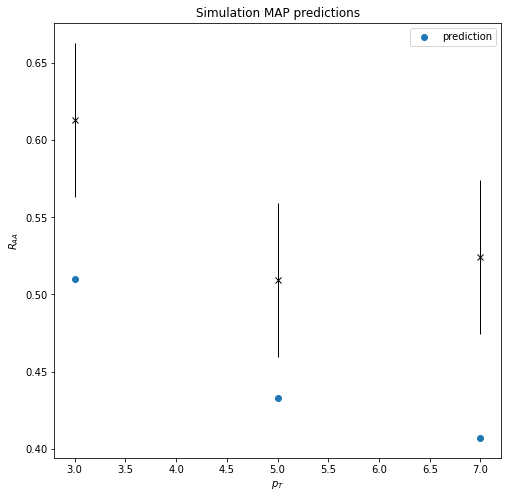

In [19]:
truth = list(true_values.values())
print(truth)
obs_1,_ = model_emukit.predict(X=np.array(truth).reshape(1,-1))
print(obs_1)
#deg_obs_2 = simulation(second_mean, *pT_range)[:,pT_obs]
# Now plot it to see what the data looks like
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x.flatten(), obs.flatten(), yerr=obserr, fmt="xk", capsize=0, elinewidth=1)
ax.scatter(x.flatten(), obs_1.flatten(), label ='prediction' )
#ax.scatter(x.flatten(), deg_obs_2.flatten(), label ='2nd Degenerate mean prediction' )
#ax.plot(x.flatten(), obs.flatten(), "k", alpha=0.3, lw=3)
#ax.set_xlim(0, 10)
ax.set_xlabel(r"$p_T$")
ax.set_ylabel(r"$R_{AA}$")
ax.set_title('Simulation MAP predictions')
ax.legend()

In [20]:
# truth = list(true_values.values())
# for i,param in enumerate(list(prior_ranges.keys())):
#     x = np.linspace(*prior_ranges[param],100)
#     y = []
#     for xx in x:
#         parameters = np.array(truth).reshape(1,-1)
#         parameters[0,i] = xx
#         parameters=parameters
#         print(parameters)
#         mu_plot, var_plot = model_emukit.predict(parameters)
#         print(mu_plot)
#         y.append(mu_plot)
#     y= np.array(y).reshape(-1,)
#     fig, ax = plt.subplots()
#     ax.plot(x,y)
#     ax.set_xlabel(param)
#     ax.set_ylabel('R_AA at 5 GeV')
#     fig.savefig(f'figures/{param}_emukit_prediction.png', dpi =50)
